In [ ]:
#This is a collection of scripts used for filling the NaN values of the data

#The NaN values were filled with a simple RF model for the building variables (confusion matrix in the end), 
#Nearest neighbour for a few NaN values in the geometry variables, and a few m2 and height variables
#The rest NaN were replaced with -999, when ML or Nearest Neighbor did not make sense

In [ ]:
import geopandas as gpd
import pandas as pd

In [1]:
# Path for geojson
file_path = 'D:/FOLDER FROM THESIS/THESIS/Processed data/Joined variables/14.12/DK8.geojson'

#load into gdf
gdf = gpd.read_file(file_path)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    # Print the first 20 rows
    print("First 20 rows:")
    print(gdf.head(20))

    # Print the last 20 rows
    print("\nLast 20 rows:")
    print(gdf.tail(20))

First 20 rows:
    byg021BygningensAnvendelse  byg026Opførelsesår  byg027OmTilbygningsår  \
0                        210.0              1950.0                    NaN   
1                        210.0              1800.0                    NaN   
2                        110.0              1800.0                 1982.0   
3                        930.0              1999.0                    NaN   
4                        110.0              1926.0                    NaN   
5                        330.0              2003.0                    NaN   
6                        230.0              1994.0                    NaN   
7                        210.0              2004.0                    NaN   
8                        930.0              1906.0                    NaN   
9                        290.0              1800.0                    NaN   
10                       210.0              1900.0                    NaN   
11                       210.0              1950.0           

In [3]:
# Rename the columns
gdf = gdf.rename(columns={'height_mea': 'height_mea_2', 'areasqm': 'areasqm_2'})


In [4]:
# Isolating rows where 'byg032YdervæggensMateriale' is not null
train_data = gdf[gdf['byg032YdervæggensMateriale'].notnull()]

# Isolating rows where 'byg032YdervæggensMateriale' is null
predict_data = gdf[gdf['byg032YdervæggensMateriale'].isnull()]

# Selecting relevant features for prediction
features = ['byg021BygningensAnvendelse', 'byg026Opførelsesår', 'byg033Tagdækningsmateriale', 
            'byg054AntalEtager', 'byg056Varmeinstallation', 'areasqm_2', 'height_mea_2']

# Preparing training data
X_train = train_data[features]
y_train = train_data['byg032YdervæggensMateriale']

# Preparing data for prediction
X_predict = predict_data[features]


In [5]:
# Fill missing values with a placeholder in the training data
X_train.fillna(-999, inplace=True)

# Fill missing values with a placeholder in the prediction data
X_predict.fillna(-999, inplace=True)


C:\Users\IM\AppData\Local\Temp\ipykernel_17552\2029100626.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.fillna(-999, inplace=True)
C:\Users\IM\AppData\Local\Temp\ipykernel_17552\2029100626.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_predict.fillna(-999, inplace=True)


In [6]:
# Verify no NaN values in the training data
print(X_train.isnull().sum())

# Verify no NaN values in the prediction data
print(X_predict.isnull().sum())


byg021BygningensAnvendelse    0
byg026Opførelsesår            0
byg033Tagdækningsmateriale    0
byg054AntalEtager             0
byg056Varmeinstallation       0
areasqm_2                     0
height_mea_2                  0
dtype: int64
byg021BygningensAnvendelse    0
byg026Opførelsesår            0
byg033Tagdækningsmateriale    0
byg054AntalEtager             0
byg056Varmeinstallation       0
areasqm_2                     0
height_mea_2                  0
dtype: int64


In [7]:
# Print data types of each column in X_train
for col in X_train.columns:
    print(col, X_train[col].dtype)


byg021BygningensAnvendelse float64
byg026Opførelsesår float64
byg033Tagdækningsmateriale object
byg054AntalEtager float64
byg056Varmeinstallation float64
areasqm_2 float64
height_mea_2 float64


In [ ]:
#The model training and filling of building variables begins beneath:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
# Identify categorical columns
categorical_columns = ['byg021BygningensAnvendelse', 'byg033Tagdækningsmateriale', 'byg056Varmeinstallation']  # Add other categorical columns as needed

# Apply one-hot encoding to the training data
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns)

# Apply one-hot encoding to the prediction data with the same columns
X_predict_encoded = pd.get_dummies(X_predict, columns=categorical_columns)

# Ensure both dataframes have the same dummy variables
X_train_encoded, X_predict_encoded = X_train_encoded.align(X_predict_encoded, join='left', axis=1)

# Fill any new NaN values that arise from alignment
X_train_encoded = X_train_encoded.fillna(-999)
X_predict_encoded = X_predict_encoded.fillna(-999)


In [10]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model with the encoded data
rf_classifier.fit(X_train_encoded, y_train)

# Predict the missing values
predicted_values = rf_classifier.predict(X_predict_encoded)

# Assign the predicted values back to the main DataFrame
gdf.loc[gdf['byg032YdervæggensMateriale'].isnull(), 'byg032YdervæggensMateriale'] = predicted_values

In [11]:
# Print the rows where 'byg032YdervæggensMateriale' was originally NaN to see the filled values
filled_rows = gdf[gdf['byg032YdervæggensMateriale'].isnull()]
print(filled_rows[['byg032YdervæggensMateriale', 'byg021BygningensAnvendelse', 'byg026Opførelsesår', 'byg033Tagdækningsmateriale', 'byg054AntalEtager', 'byg056Varmeinstallation', 'areasqm_2', 'height_mea_2']])

Empty DataFrame
Columns: [byg032YdervæggensMateriale, byg021BygningensAnvendelse, byg026Opførelsesår, byg033Tagdækningsmateriale, byg054AntalEtager, byg056Varmeinstallation, areasqm_2, height_mea_2]
Index: []


In [12]:
# Check if there are still NaN values in 'byg032YdervæggensMateriale'
print("Remaining NaN values in 'byg032YdervæggensMateriale':", gdf['byg032YdervæggensMateriale'].isnull().sum())


Remaining NaN values in 'byg032YdervæggensMateriale': 0


In [13]:
# Print the first 20 rows of the DataFrame
print(gdf.head(200)[['byg032YdervæggensMateriale', 'byg021BygningensAnvendelse', 'byg026Opførelsesår', 'byg033Tagdækningsmateriale', 'byg054AntalEtager', 'byg056Varmeinstallation', 'areasqm_2', 'height_mea_2']])


    byg032YdervæggensMateriale  byg021BygningensAnvendelse  \
0                            1                       210.0   
1                            4                       210.0   
2                            4                       110.0   
3                            5                       930.0   
4                            1                       110.0   
..                         ...                         ...   
195                          5                       920.0   
196                          2                       210.0   
197                          8                       210.0   
198                          1                       210.0   
199                          1                       210.0   

     byg026Opførelsesår byg033Tagdækningsmateriale  byg054AntalEtager  \
0                1950.0                          4                1.0   
1                1800.0                          6                1.0   
2                1800.0             

In [14]:
# Isolating rows where 'byg033Tagdækningsmateriale' is not null
train_data = gdf[gdf['byg033Tagdækningsmateriale'].notnull()]

# Isolating rows where 'byg033Tagdækningsmateriale' is null
predict_data = gdf[gdf['byg033Tagdækningsmateriale'].isnull()]

# Selecting relevant features for prediction
features = ['byg021BygningensAnvendelse', 'byg026Opførelsesår', 'byg032YdervæggensMateriale', 
            'byg054AntalEtager', 'byg056Varmeinstallation', 'areasqm_2', 'height_mea_2']

# Preparing training data
X_train = train_data[features]
y_train = train_data['byg033Tagdækningsmateriale']

# Preparing data for prediction
X_predict = predict_data[features]


In [15]:
# Identify categorical columns (update as needed)
categorical_columns = ['byg021BygningensAnvendelse', 'byg032YdervæggensMateriale', 'byg056Varmeinstallation']

# One-hot encoding
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns)
X_predict_encoded = pd.get_dummies(X_predict, columns=categorical_columns)

# Ensure both dataframes have the same dummy variables
X_train_encoded, X_predict_encoded = X_train_encoded.align(X_predict_encoded, join='left', axis=1)

# Fill any new NaN values that arise from alignment
X_train_encoded.fillna(-999, inplace=True)
X_predict_encoded.fillna(-999, inplace=True)


In [16]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model with the encoded data
rf_classifier.fit(X_train_encoded, y_train)

# Predict the missing values
predicted_values = rf_classifier.predict(X_predict_encoded)

# Assign the predicted values back to the main DataFrame
gdf.loc[gdf['byg033Tagdækningsmateriale'].isnull(), 'byg033Tagdækningsmateriale'] = predicted_values


In [17]:
# Print the first 20 rows of the DataFrame
print(gdf.head(20)[['byg032YdervæggensMateriale', 'byg021BygningensAnvendelse', 'byg026Opførelsesår', 'byg033Tagdækningsmateriale', 'byg054AntalEtager', 'byg056Varmeinstallation', 'areasqm_2', 'height_mea_2']])


   byg032YdervæggensMateriale  byg021BygningensAnvendelse  byg026Opførelsesår  \
0                           1                       210.0              1950.0   
1                           4                       210.0              1800.0   
2                           4                       110.0              1800.0   
3                           5                       930.0              1999.0   
4                           1                       110.0              1926.0   
5                           5                       330.0              2003.0   
6                           5                       230.0              1994.0   
7                           5                       210.0              2004.0   
8                           4                       930.0              1906.0   
9                           4                       290.0              1800.0   
10                          1                       210.0              1900.0   
11                          

In [18]:
# Isolating rows where 'byg056Varmeinstallation' is not null
train_data = gdf[gdf['byg056Varmeinstallation'].notnull()]

# Isolating rows where 'byg056Varmeinstallation' is null
predict_data = gdf[gdf['byg056Varmeinstallation'].isnull()]

# Selecting relevant features for prediction
features = ['byg021BygningensAnvendelse', 'byg026Opførelsesår', 'byg032YdervæggensMateriale', 
            'byg054AntalEtager', 'byg033Tagdækningsmateriale', 'areasqm_2', 'height_mea_2']

# Preparing training data
X_train = train_data[features]
y_train = train_data['byg056Varmeinstallation']

# Preparing data for prediction
X_predict = predict_data[features]


In [19]:
# Identify categorical columns (update as needed)
categorical_columns = ['byg021BygningensAnvendelse', 'byg032YdervæggensMateriale', 'byg033Tagdækningsmateriale']

# One-hot encoding
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns)
X_predict_encoded = pd.get_dummies(X_predict, columns=categorical_columns)

# Ensure both dataframes have the same dummy variables
X_train_encoded, X_predict_encoded = X_train_encoded.align(X_predict_encoded, join='left', axis=1)

# Fill any new NaN values that arise from alignment
X_train_encoded.fillna(-999, inplace=True)
X_predict_encoded.fillna(-999, inplace=True)


In [20]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model with the encoded data
rf_classifier.fit(X_train_encoded, y_train)

# Predict the missing values
predicted_values = rf_classifier.predict(X_predict_encoded)

# Assign the predicted values back to the main DataFrame
gdf.loc[gdf['byg056Varmeinstallation'].isnull(), 'byg056Varmeinstallation'] = predicted_values

In [21]:
# Print the first 20 rows of the DataFrame
print(gdf.head(20)[['byg032YdervæggensMateriale', 'byg021BygningensAnvendelse', 'byg026Opførelsesår', 'byg033Tagdækningsmateriale', 'byg054AntalEtager', 'byg056Varmeinstallation', 'areasqm_2', 'height_mea_2']])


   byg032YdervæggensMateriale  byg021BygningensAnvendelse  byg026Opførelsesår  \
0                           1                       210.0              1950.0   
1                           4                       210.0              1800.0   
2                           4                       110.0              1800.0   
3                           5                       930.0              1999.0   
4                           1                       110.0              1926.0   
5                           5                       330.0              2003.0   
6                           5                       230.0              1994.0   
7                           5                       210.0              2004.0   
8                           4                       930.0              1906.0   
9                           4                       290.0              1800.0   
10                          1                       210.0              1900.0   
11                          

In [22]:
print("Number of null values in byg033Tagdækningsmateriale:", gdf['byg033Tagdækningsmateriale'].isnull().sum())
print("Number of null values in byg056Varmeinstallation:", gdf['byg056Varmeinstallation'].isnull().sum())
print("Number of null values in byg032YdervæggensMateriale:", gdf['byg032YdervæggensMateriale'].isnull().sum())

Number of null values: 0


In [25]:
# Isolating rows where 'byg026Opførelsesår' is not null
train_data = gdf[gdf['byg026Opførelsesår'].notnull()]

# Isolating rows where 'byg026Opførelsesår' is null
predict_data = gdf[gdf['byg026Opførelsesår'].isnull()]

# Selecting relevant features for prediction
features = ['byg021BygningensAnvendelse', 'byg056Varmeinstallation', 'byg032YdervæggensMateriale', 
            'byg054AntalEtager', 'byg033Tagdækningsmateriale', 'areasqm_2', 'height_mea_2']

# Preparing training data
X_train = train_data[features]
y_train = train_data['byg026Opførelsesår']

# Preparing data for prediction
X_predict = predict_data[features]

In [26]:
# Identify categorical columns (update as needed)
categorical_columns = ['byg021BygningensAnvendelse', 'byg032YdervæggensMateriale', 'byg033Tagdækningsmateriale', 'byg056Varmeinstallation']

# One-hot encoding
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns)
X_predict_encoded = pd.get_dummies(X_predict, columns=categorical_columns)

# Ensure both dataframes have the same dummy variables
X_train_encoded, X_predict_encoded = X_train_encoded.align(X_predict_encoded, join='left', axis=1)

# Fill any new NaN values that arise from alignment
X_train_encoded.fillna(-999, inplace=True)
X_predict_encoded.fillna(-999, inplace=True)

In [27]:
# Isolating rows where 'byg054AntalEtager' is not null
train_data = gdf[gdf['byg054AntalEtager'].notnull()]

# Isolating rows where 'byg054AntalEtager' is null
predict_data = gdf[gdf['byg054AntalEtager'].isnull()]

# Selecting relevant features for prediction
features = ['byg021BygningensAnvendelse', 'byg056Varmeinstallation', 'byg032YdervæggensMateriale', 
            'byg026Opførelsesår', 'byg033Tagdækningsmateriale', 'areasqm_2', 'height_mea_2']

# Preparing training data
X_train = train_data[features]
y_train = train_data['byg054AntalEtager']

# Preparing data for prediction
X_predict = predict_data[features]

In [28]:
# Identify categorical columns (update as needed)
categorical_columns = ['byg021BygningensAnvendelse', 'byg032YdervæggensMateriale', 'byg033Tagdækningsmateriale', 'byg056Varmeinstallation']

# One-hot encoding
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns)
X_predict_encoded = pd.get_dummies(X_predict, columns=categorical_columns)

# Ensure both dataframes have the same dummy variables
X_train_encoded, X_predict_encoded = X_train_encoded.align(X_predict_encoded, join='left', axis=1)

# Fill any new NaN values that arise from alignment
X_train_encoded.fillna(-999, inplace=True)
X_predict_encoded.fillna(-999, inplace=True)

In [29]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model with the encoded data
rf_classifier.fit(X_train_encoded, y_train)

# Predict the missing values
predicted_values = rf_classifier.predict(X_predict_encoded)

# Assign the predicted values back to the main DataFrame
gdf.loc[gdf['byg054AntalEtager'].isnull(), 'byg054AntalEtager'] = predicted_values

In [30]:
# Print the first 20 rows of the DataFrame
print(gdf.head(20)[['byg032YdervæggensMateriale', 'byg021BygningensAnvendelse', 'byg026Opførelsesår', 'byg033Tagdækningsmateriale', 'byg054AntalEtager', 'byg056Varmeinstallation', 'areasqm_2', 'height_mea_2']])


   byg032YdervæggensMateriale  byg021BygningensAnvendelse  byg026Opførelsesår  \
0                           1                       210.0              1950.0   
1                           4                       210.0              1800.0   
2                           4                       110.0              1800.0   
3                           5                       930.0              1999.0   
4                           1                       110.0              1926.0   
5                           5                       330.0              2003.0   
6                           5                       230.0              1994.0   
7                           5                       210.0              2004.0   
8                           4                       930.0              1906.0   
9                           4                       290.0              1800.0   
10                          1                       210.0              1900.0   
11                          

In [31]:
# Set option to display all rows
pd.set_option('display.max_rows', None)

# Count of null/NaN values for each field
null_counts = gdf.isna().sum()

print("Count of null/NaN values for each field:")
print(null_counts)

# Reset display option if needed
pd.reset_option('display.max_rows')


Count of null/NaN values for each field:
byg021BygningensAnvendelse           21618
byg026Opførelsesår                  731477
byg027OmTilbygningsår              4181896
byg032YdervæggensMateriale               0
byg033Tagdækningsmateriale               0
byg054AntalEtager                        0
byg056Varmeinstallation                  0
byg404Koordinat                          0
byg406Koordinatsystem                    5
id_lokalId                               0
eta006BygningensEtagebetegnelse    4491310
eta020SamletArealAfEtage           4492498
bygning                            2781810
x                                        0
y                                        0
redoxgrid_code                           0
id.lokalId                          105623
e_value                             152346
g_value                             152346
count                               105623
building                            152346
b_div_c                             152346
Area         

In [32]:
# Print all unique categories in 'byg021BygningensAnvendelse'
unique_categories = gdf['byg021BygningensAnvendelse'].unique()
print("Unique categories in 'byg021BygningensAnvendelse':", unique_categories)


Unique categories in 'byg021BygningensAnvendelse': [210. 110. 930. 330. 230. 290. 970. 216. 217. 219. 212. 120. 333. 211.
 220. 910. 999. 920. 130. 410. 218. 321. 313. 323. 223. 319.  nan 590.
 510. 940. 332. 190. 310. 530. 521. 529. 535. 950. 522. 213. 320. 520.
 539. 532. 531. 990. 523. 585. 490. 185. 140. 960. 416. 322. 390. 329.
 440. 231. 214. 232. 222. 229. 239. 420. 339. 233. 132. 421. 430. 131.
 431. 533. 414. 540. 412. 150. 325. 415. 433. 215. 442. 449. 419. 160.
 334. 331. 311. 312. 314. 429. 441. 234. 422. 439. 221. 315. 444. 411.
 534. 121. 122. 324. 413. 443. 432.]


In [33]:
category_mapping = {
    110: 1, 120: 2, 121: 3, 122: 2, 130: 4, 131: 4, 132: 4, 140: 5, 150: 6, 160: 21, 185: 7, 190: 7, 
    210: 8, 211: 9, 212: 9, 213: 9, 214: 9, 215: 10, 216: 9, 217: 8, 218: 9, 219: 8, 220: 11, 221: 11, 
    222: 11, 223: 11, 229: 11, 230: 12, 231: 12, 232: 12, 233: 12, 234: 12, 239: 12, 290: 8, 310: 13, 
    311: 13, 312: 13, 313: 13, 314: 13, 315: 13, 319: 13, 320: 14, 321: 14, 322: 14, 323: 14, 324: 14, 
    325: 14, 329: 14, 330: 15, 331: 15, 332: 15, 333: 15, 334: 15, 390: 14, 410: 16, 411: 16, 412: 16, 
    413: 16, 414: 16, 415: 16, 416: 16, 419: 16, 420: 17, 421: 17, 422: 17, 429: 17, 430: 18, 431: 18, 
    432: 18, 433: 18, 439: 18, 440: 19, 441: 19, 442: 19, 443: 19, 444: 19, 449: 19, 451: 19, 490: 19, 
    510: 20, 520: 20, 521: 20, 522: 20, 523: 20, 529: 20, 530: 21, 531: 21, 532: 21, 533: 21, 534: 21, 
    535: 21, 539: 21, 540: 20, 585: 20, 590: 20, 970: 8, 990: 22, 999: 23, 
    910: 99, 920: 99, 930: 99, 940: 99, 950: 99, 960: 99
}

In [34]:
# Apply the mapping to the 'byg021BygningensAnvendelse' column
gdf['byg021BygningensAnvendelse_grouped'] = gdf['byg021BygningensAnvendelse'].map(category_mapping)


In [35]:
# Print the first few rows to verify the new grouped column
print(gdf[['byg021BygningensAnvendelse', 'byg021BygningensAnvendelse_grouped']].head())


   byg021BygningensAnvendelse  byg021BygningensAnvendelse_grouped
0                       210.0                                 8.0
1                       210.0                                 8.0
2                       110.0                                 1.0
3                       930.0                                99.0
4                       110.0                                 1.0


In [36]:
# Print all unique categories in 'byg021BygningensAnvendelse'
unique_categories = gdf['byg021BygningensAnvendelse_grouped'].unique()
print("Unique categories in 'byg021BygningensAnvendelse_grouped':", unique_categories)


Unique categories in 'byg021BygningensAnvendelse_grouped': [ 8.  1. 99. 15. 12.  9.  2. 11. 23.  4. 16. 14. 13. nan 20.  7. 21. 22.
 19.  5. 17. 18.  6. 10.  3.]


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting relevant features for prediction
features = ['byg032YdervæggensMateriale', 'byg026Opførelsesår', 'byg033Tagdækningsmateriale', 'byg054AntalEtager', 'byg056Varmeinstallation', 'areasqm_2', 'height_mea_2']

# Preparing the dataset
X = gdf[features]
y = gdf['byg021BygningensAnvendelse_grouped']

# Handling missing values in features
X.fillna(-999, inplace=True)

# Exclude rows where the target is NaN from the training set
train_indices = y.notnull()
X_train = X[train_indices]
y_train = y[train_indices]

# One-hot encoding for categorical variables in X_train
X_train_encoded = pd.get_dummies(X_train)

# Splitting the dataset into training and testing sets
X_train_final, X_test, y_train_final, y_test = train_test_split(X_train_encoded, y_train, test_size=0.3, random_state=42)


C:\Users\IM\AppData\Local\Temp\ipykernel_17552\2143769024.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(-999, inplace=True)


In [38]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train_final, y_train_final)


RandomForestClassifier(random_state=42)

Classification Report:
               precision    recall  f1-score   support

         1.0       0.45      0.26      0.33     35721
         2.0       0.79      0.91      0.84    359338
         3.0       0.74      0.42      0.54       238
         4.0       0.73      0.61      0.67     83886
         5.0       0.70      0.68      0.69     29353
         6.0       0.62      0.29      0.39       617
         7.0       0.27      0.07      0.11      2463
         8.0       0.65      0.68      0.66    135864
         9.0       0.52      0.11      0.18      7254
        10.0       0.38      0.09      0.14       229
        11.0       0.42      0.27      0.33     21112
        12.0       0.40      0.12      0.19      6117
        13.0       0.39      0.09      0.14      5090
        14.0       0.37      0.21      0.27     28622
        15.0       0.25      0.05      0.09      4598
        16.0       0.57      0.22      0.32      4154
        17.0       0.30      0.14      0.19      6051
   

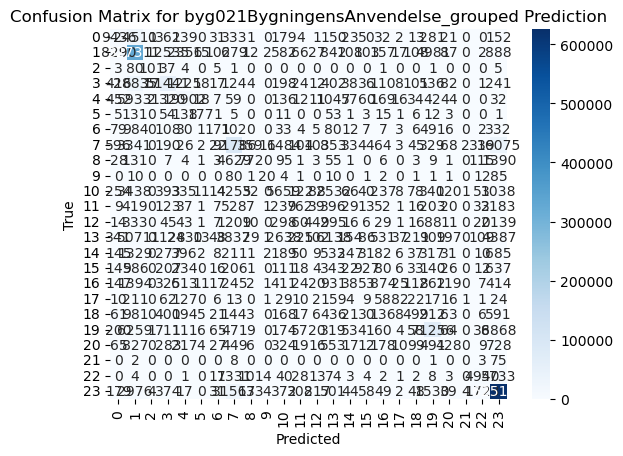

In [39]:
# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for byg021BygningensAnvendelse_grouped Prediction')
plt.show()

#Confusion matrix showed reasonable results with an overall accuracy of 0.81

In [40]:
# Isolate the subset where 'byg021BygningensAnvendelse_grouped' is NaN
predict_data = gdf[gdf['byg021BygningensAnvendelse_grouped'].isnull()]

# Apply the same preprocessing to the prediction data
X_predict = predict_data[features]
X_predict.fillna(-999, inplace=True)  # Handle missing values in features
X_predict_encoded = pd.get_dummies(X_predict)  # Apply one-hot encoding

# Align the columns of X_predict_encoded with those of X_train_encoded
X_predict_encoded = X_predict_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)


C:\Users\IM\AppData\Local\Temp\ipykernel_17552\3548168525.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_predict.fillna(-999, inplace=True)  # Handle missing values in features


In [41]:
# Predict the missing 'byg021BygningensAnvendelse_grouped' values
predicted_values = rf_classifier.predict(X_predict_encoded)

# Assign the predicted values back to the DataFrame
gdf.loc[gdf['byg021BygningensAnvendelse_grouped'].isnull(), 'byg021BygningensAnvendelse_grouped'] = predicted_values


In [42]:
# Verify the changes
print(gdf['byg021BygningensAnvendelse_grouped'].isnull().sum())  # Should be 0 if all NaNs are filled


0


In [44]:
# Fill NaN values in specified columns with -999
gdf['byg027OmTilbygningsår'].fillna(-999, inplace=True)
gdf['eta006BygningensEtagebetegnelse'].fillna(-999, inplace=True)
gdf['eta020SamletArealAfEtage'].fillna(-999, inplace=True)

# Verify the changes
print("Count of null/NaN values after filling:")
print(gdf[['byg027OmTilbygningsår', 'eta006BygningensEtagebetegnelse', 'eta020SamletArealAfEtage']].isna().sum())


Count of null/NaN values after filling:
byg027OmTilbygningsår              0
eta006BygningensEtagebetegnelse    0
eta020SamletArealAfEtage           0
dtype: int64


In [45]:
# Set option to display all rows
pd.set_option('display.max_rows', None)

# Count of null/NaN values for each field
null_counts = gdf.isna().sum()

print("Count of null/NaN values for each field:")
print(null_counts)

# Reset display option if needed
pd.reset_option('display.max_rows')

Count of null/NaN values for each field:
byg021BygningensAnvendelse              21618
byg026Opførelsesår                     731477
byg027OmTilbygningsår                       0
byg032YdervæggensMateriale                  0
byg033Tagdækningsmateriale                  0
byg054AntalEtager                           0
byg056Varmeinstallation                     0
byg404Koordinat                             0
byg406Koordinatsystem                       5
id_lokalId                                  0
eta006BygningensEtagebetegnelse             0
eta020SamletArealAfEtage                    0
bygning                               2781810
x                                           0
y                                           0
redoxgrid_code                              0
id.lokalId                             105623
e_value                                152346
g_value                                152346
count                                  105623
building                               

In [ ]:
#Nearest neighbour is used to fill the following variables

In [54]:
from sklearn.impute import KNNImputer
import numpy as np

# List of fields to be filled
fields_to_fill = ['b_div_c', 'doegn2aars', 'dagligmaxt', 'frostdoegn', 'middelvind', 'height_mea_2', 'byg026Opførelsesår', 'areasqm_2']

# Coordinates
coordinates = gdf[['x', 'y']]

# Create the KNN imputer with 2 neighbors
imputer = KNNImputer(n_neighbors=2)

# Process each field individually
for field in fields_to_fill:
    print(f"Imputing field: {field}")
    # Combine coordinates with the current field
    field_data = gdf[[field]]
    combined_data = np.hstack((coordinates, field_data))

    # Apply the imputer
    imputed_data = imputer.fit_transform(combined_data)

    # Update the field in the original dataframe
    gdf[field] = imputed_data[:, 2]  # 2 is the index of the field in combined_data

    # Print progress
    for i in range(0, len(gdf), 10000):
        print(f"Processed {i} rows for field {field}")

print("Imputation completed.")


Imputing field: b_div_c
Processed 0 rows for field b_div_c
Processed 10000 rows for field b_div_c
Processed 20000 rows for field b_div_c
Processed 30000 rows for field b_div_c
Processed 40000 rows for field b_div_c
Processed 50000 rows for field b_div_c
Processed 60000 rows for field b_div_c
Processed 70000 rows for field b_div_c
Processed 80000 rows for field b_div_c
Processed 90000 rows for field b_div_c
Processed 100000 rows for field b_div_c
Processed 110000 rows for field b_div_c
Processed 120000 rows for field b_div_c
Processed 130000 rows for field b_div_c
Processed 140000 rows for field b_div_c
Processed 150000 rows for field b_div_c
Processed 160000 rows for field b_div_c
Processed 170000 rows for field b_div_c
Processed 180000 rows for field b_div_c
Processed 190000 rows for field b_div_c
Processed 200000 rows for field b_div_c
Processed 210000 rows for field b_div_c
Processed 220000 rows for field b_div_c
Processed 230000 rows for field b_div_c
Processed 240000 rows for fiel

Processed 0 rows for field doegn2aars
Processed 10000 rows for field doegn2aars
Processed 20000 rows for field doegn2aars
Processed 30000 rows for field doegn2aars
Processed 40000 rows for field doegn2aars
Processed 50000 rows for field doegn2aars
Processed 60000 rows for field doegn2aars
Processed 70000 rows for field doegn2aars
Processed 80000 rows for field doegn2aars
Processed 90000 rows for field doegn2aars
Processed 100000 rows for field doegn2aars
Processed 110000 rows for field doegn2aars
Processed 120000 rows for field doegn2aars
Processed 130000 rows for field doegn2aars
Processed 140000 rows for field doegn2aars
Processed 150000 rows for field doegn2aars
Processed 160000 rows for field doegn2aars
Processed 170000 rows for field doegn2aars
Processed 180000 rows for field doegn2aars
Processed 190000 rows for field doegn2aars
Processed 200000 rows for field doegn2aars
Processed 210000 rows for field doegn2aars
Processed 220000 rows for field doegn2aars
Processed 230000 rows for

Processed 0 rows for field dagligmaxt
Processed 10000 rows for field dagligmaxt
Processed 20000 rows for field dagligmaxt
Processed 30000 rows for field dagligmaxt
Processed 40000 rows for field dagligmaxt
Processed 50000 rows for field dagligmaxt
Processed 60000 rows for field dagligmaxt
Processed 70000 rows for field dagligmaxt
Processed 80000 rows for field dagligmaxt
Processed 90000 rows for field dagligmaxt
Processed 100000 rows for field dagligmaxt
Processed 110000 rows for field dagligmaxt
Processed 120000 rows for field dagligmaxt
Processed 130000 rows for field dagligmaxt
Processed 140000 rows for field dagligmaxt
Processed 150000 rows for field dagligmaxt
Processed 160000 rows for field dagligmaxt
Processed 170000 rows for field dagligmaxt
Processed 180000 rows for field dagligmaxt
Processed 190000 rows for field dagligmaxt
Processed 200000 rows for field dagligmaxt
Processed 210000 rows for field dagligmaxt
Processed 220000 rows for field dagligmaxt
Processed 230000 rows for

Processed 0 rows for field frostdoegn
Processed 10000 rows for field frostdoegn
Processed 20000 rows for field frostdoegn
Processed 30000 rows for field frostdoegn
Processed 40000 rows for field frostdoegn
Processed 50000 rows for field frostdoegn
Processed 60000 rows for field frostdoegn
Processed 70000 rows for field frostdoegn
Processed 80000 rows for field frostdoegn
Processed 90000 rows for field frostdoegn
Processed 100000 rows for field frostdoegn
Processed 110000 rows for field frostdoegn
Processed 120000 rows for field frostdoegn
Processed 130000 rows for field frostdoegn
Processed 140000 rows for field frostdoegn
Processed 150000 rows for field frostdoegn
Processed 160000 rows for field frostdoegn
Processed 170000 rows for field frostdoegn
Processed 180000 rows for field frostdoegn
Processed 190000 rows for field frostdoegn
Processed 200000 rows for field frostdoegn
Processed 210000 rows for field frostdoegn
Processed 220000 rows for field frostdoegn
Processed 230000 rows for

Processed 0 rows for field middelvind
Processed 10000 rows for field middelvind
Processed 20000 rows for field middelvind
Processed 30000 rows for field middelvind
Processed 40000 rows for field middelvind
Processed 50000 rows for field middelvind
Processed 60000 rows for field middelvind
Processed 70000 rows for field middelvind
Processed 80000 rows for field middelvind
Processed 90000 rows for field middelvind
Processed 100000 rows for field middelvind
Processed 110000 rows for field middelvind
Processed 120000 rows for field middelvind
Processed 130000 rows for field middelvind
Processed 140000 rows for field middelvind
Processed 150000 rows for field middelvind
Processed 160000 rows for field middelvind
Processed 170000 rows for field middelvind
Processed 180000 rows for field middelvind
Processed 190000 rows for field middelvind
Processed 200000 rows for field middelvind
Processed 210000 rows for field middelvind
Processed 220000 rows for field middelvind
Processed 230000 rows for

Processed 0 rows for field height_mea_2
Processed 10000 rows for field height_mea_2
Processed 20000 rows for field height_mea_2
Processed 30000 rows for field height_mea_2
Processed 40000 rows for field height_mea_2
Processed 50000 rows for field height_mea_2
Processed 60000 rows for field height_mea_2
Processed 70000 rows for field height_mea_2
Processed 80000 rows for field height_mea_2
Processed 90000 rows for field height_mea_2
Processed 100000 rows for field height_mea_2
Processed 110000 rows for field height_mea_2
Processed 120000 rows for field height_mea_2
Processed 130000 rows for field height_mea_2
Processed 140000 rows for field height_mea_2
Processed 150000 rows for field height_mea_2
Processed 160000 rows for field height_mea_2
Processed 170000 rows for field height_mea_2
Processed 180000 rows for field height_mea_2
Processed 190000 rows for field height_mea_2
Processed 200000 rows for field height_mea_2
Processed 210000 rows for field height_mea_2
Processed 220000 rows fo

Processed 0 rows for field byg026Opførelsesår
Processed 10000 rows for field byg026Opførelsesår
Processed 20000 rows for field byg026Opførelsesår
Processed 30000 rows for field byg026Opførelsesår
Processed 40000 rows for field byg026Opførelsesår
Processed 50000 rows for field byg026Opførelsesår
Processed 60000 rows for field byg026Opførelsesår
Processed 70000 rows for field byg026Opførelsesår
Processed 80000 rows for field byg026Opførelsesår
Processed 90000 rows for field byg026Opførelsesår
Processed 100000 rows for field byg026Opførelsesår
Processed 110000 rows for field byg026Opførelsesår
Processed 120000 rows for field byg026Opførelsesår
Processed 130000 rows for field byg026Opførelsesår
Processed 140000 rows for field byg026Opførelsesår
Processed 150000 rows for field byg026Opførelsesår
Processed 160000 rows for field byg026Opførelsesår
Processed 170000 rows for field byg026Opførelsesår
Processed 180000 rows for field byg026Opførelsesår
Processed 190000 rows for field byg026Opførel

Processed 0 rows for field areasqm_2
Processed 10000 rows for field areasqm_2
Processed 20000 rows for field areasqm_2
Processed 30000 rows for field areasqm_2
Processed 40000 rows for field areasqm_2
Processed 50000 rows for field areasqm_2
Processed 60000 rows for field areasqm_2
Processed 70000 rows for field areasqm_2
Processed 80000 rows for field areasqm_2
Processed 90000 rows for field areasqm_2
Processed 100000 rows for field areasqm_2
Processed 110000 rows for field areasqm_2
Processed 120000 rows for field areasqm_2
Processed 130000 rows for field areasqm_2
Processed 140000 rows for field areasqm_2
Processed 150000 rows for field areasqm_2
Processed 160000 rows for field areasqm_2
Processed 170000 rows for field areasqm_2
Processed 180000 rows for field areasqm_2
Processed 190000 rows for field areasqm_2
Processed 200000 rows for field areasqm_2
Processed 210000 rows for field areasqm_2
Processed 220000 rows for field areasqm_2
Processed 230000 rows for field areasqm_2
Proces

In [ ]:
from sklearn.impute import KNNImputer

# List of fields to be filled
fields_to_fill = ['landscape', 'TSYM']

# Assuming 'x' and 'y' are the coordinates
features = gdf[['x', 'y'] + fields_to_fill]

# Create the KNN imputer
imputer = KNNImputer(n_neighbors=5)  # Adjust the number of neighbors as needed

# Apply the imputer
features_imputed = imputer.fit_transform(features)

# Update the fields in your original dataframe
for i, field in enumerate(fields_to_fill):
    gdf[field] = features_imputed[:, 2 + i]  # 2 is offset for 'x' and 'y' columns

In [60]:
# Define file path
output_file_path = r'D:/FOLDER FROM THESIS/THESIS/Processed data/Joined variables/14.12/DK_processed1.geojson'

# Save the GeoDataFrame as a GeoJSON file
gdf.to_file(output_file_path, driver='GeoJSON')
